In [1]:
import ensaio
import pandas as pd

fname = ensaio.fetch_bushveld_gravity(version=1)
data = pd.read_csv(fname)
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,gravity_bouguer_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,-113.259165
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,-122.662101
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,-121.339321
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,-113.817543
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,-130.460126
...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,-39.543608
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,16.602026
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,22.456674
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,-20.419870


In [2]:
import pyproj
import verde as vd

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
region = vd.get_region((easting, northing))

In [3]:
import harmonica as hm

equivalent_sources = hm.EquivalentSources(damping=10)
equivalent_sources

,damping,10
,points,None
,depth,'default'
,block_size,None
,parallel,True
,dtype,'float64'


In [4]:
coordinates = (easting, northing, data.height_geometric_m)
equivalent_sources.fit(coordinates, data.gravity_disturbance_mgal)

,damping,10
,points,None
,depth,'default'
,block_size,None
,parallel,True
,dtype,'float64'


In [5]:
disturbance = equivalent_sources.predict(coordinates)

In [6]:
 import pygmt

 # Needed so that displaying works on jupyter-sphinx and sphinx-gallery at
 # the same time. Using PYGMT_USE_EXTERNAL_DISPLAY="false" in the Makefile
 # for sphinx-gallery to work means that fig.show won't display anything here
 # either.
 pygmt.set_display(method="notebook")

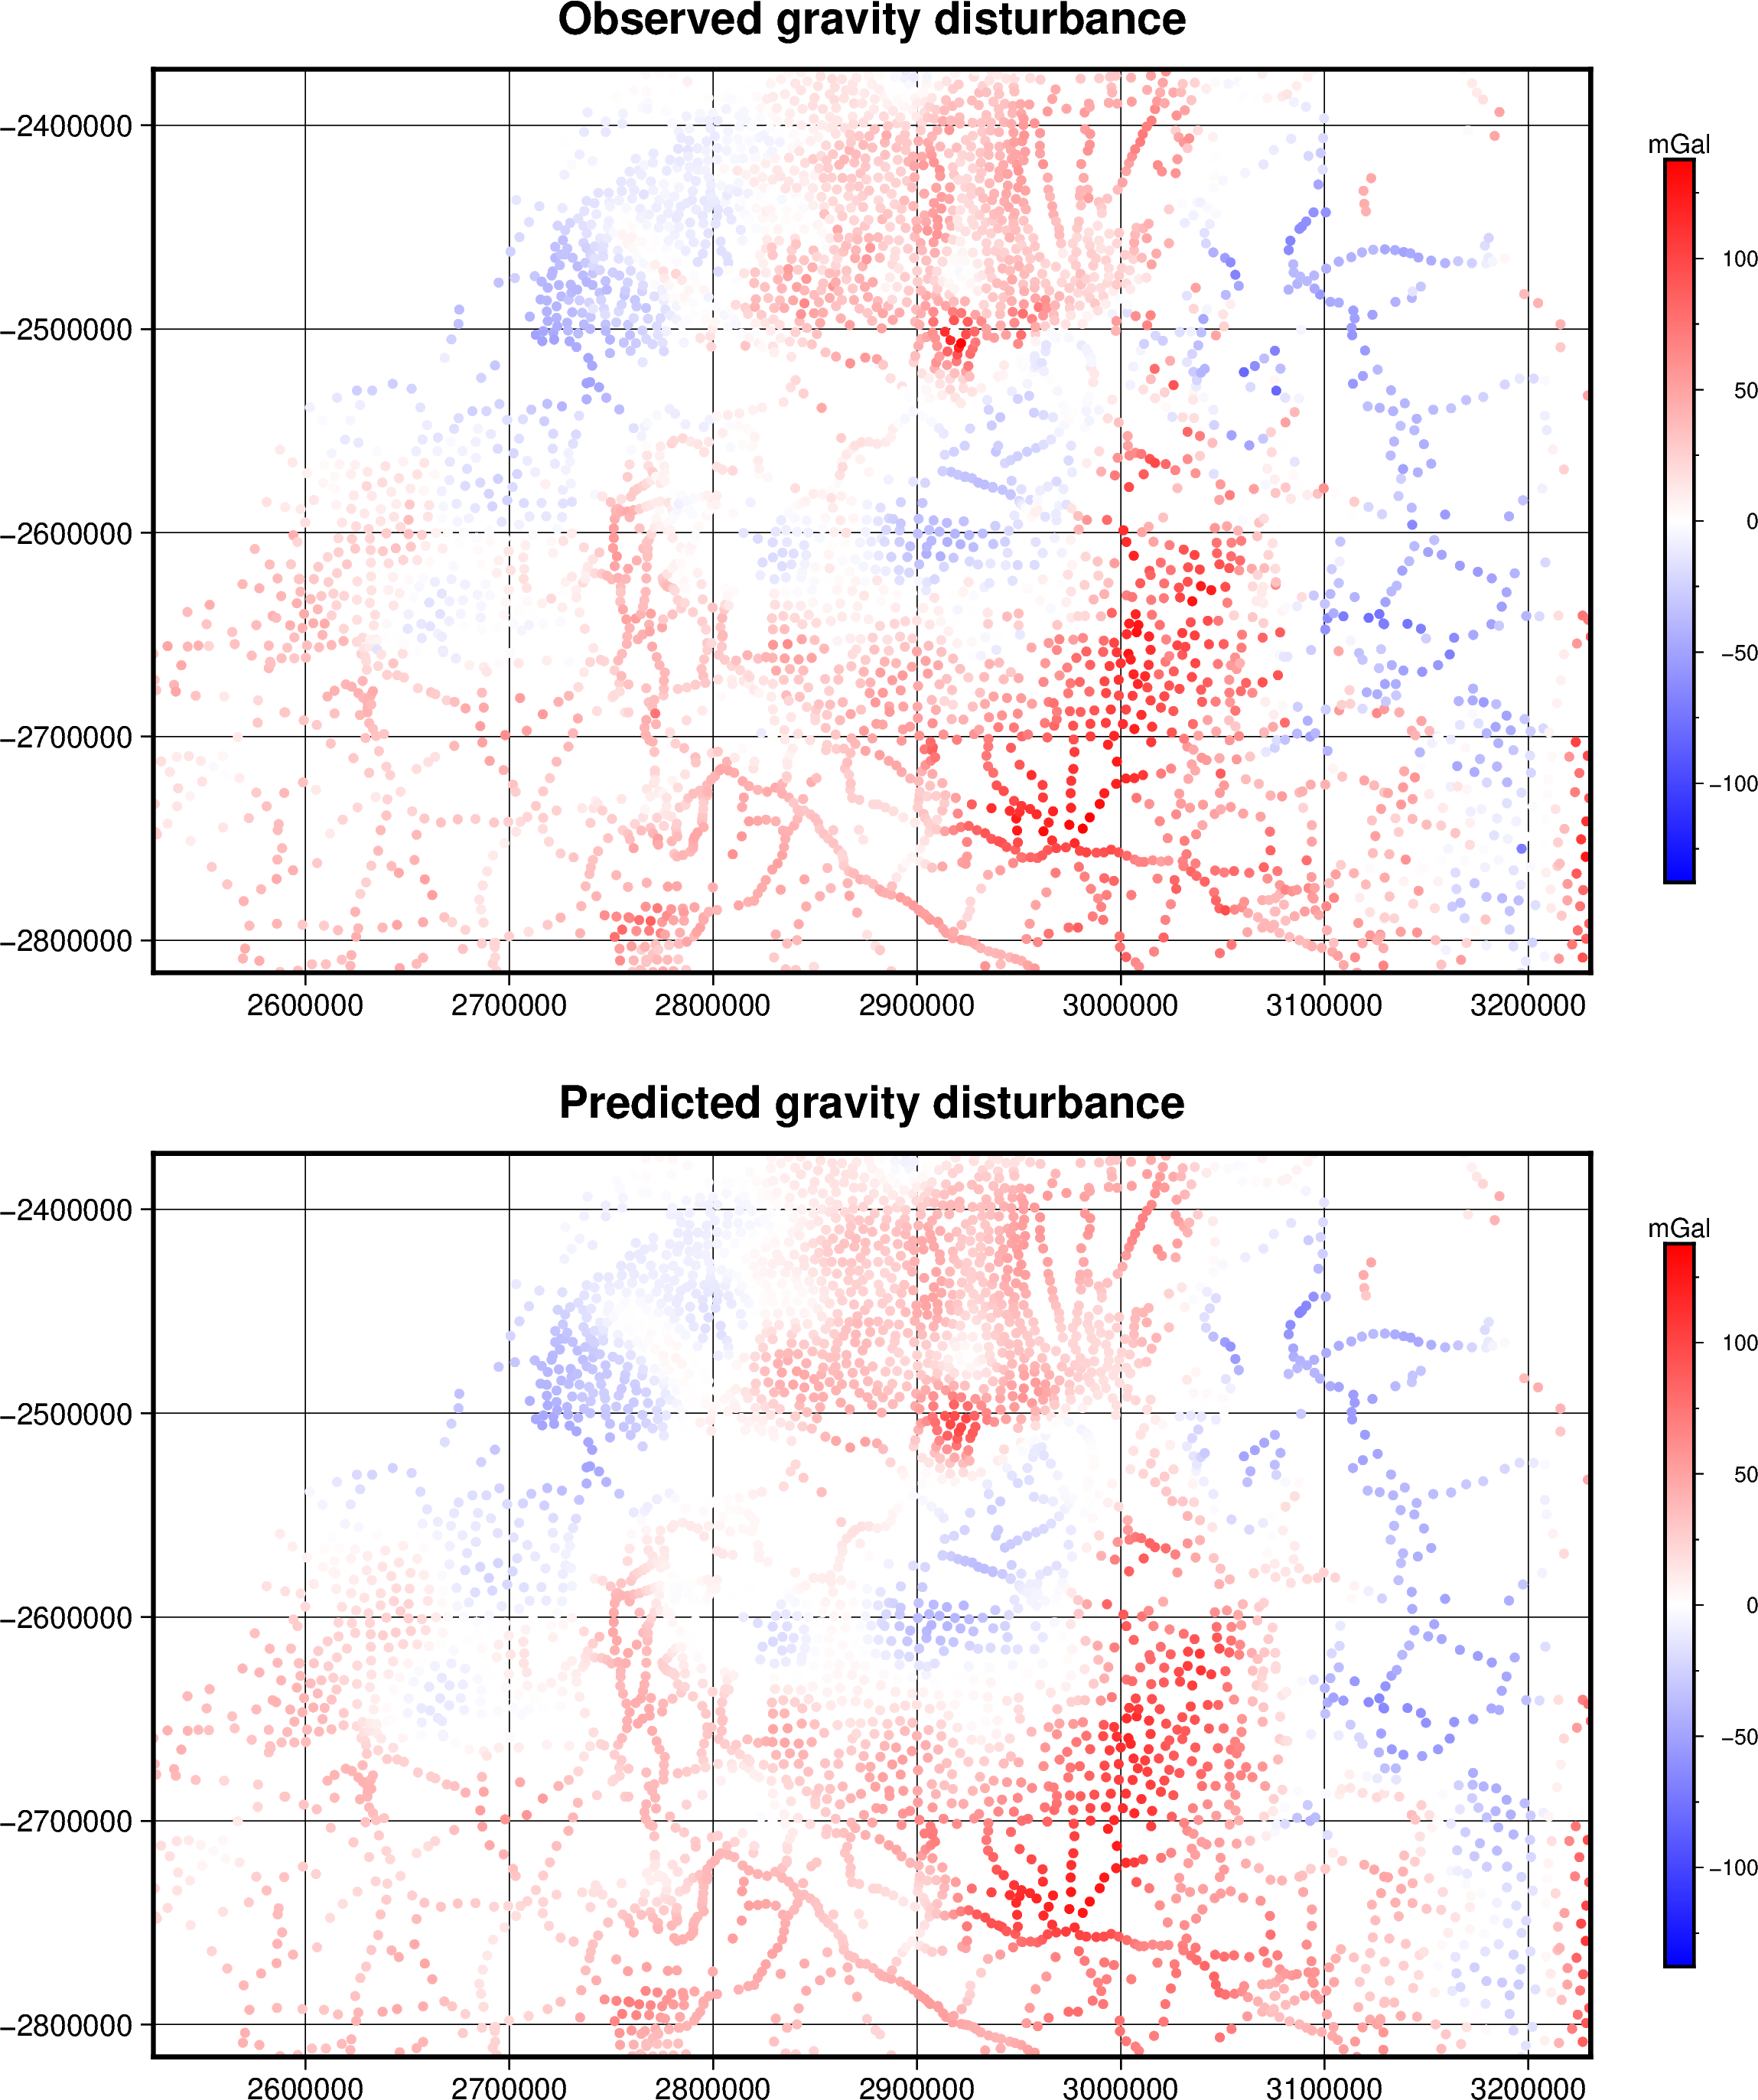

In [7]:
import pygmt

# Get max absolute value for the observed gravity disturbance
maxabs = vd.maxabs(data.gravity_disturbance_mgal)

# Set figure properties
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
title="Predicted gravity disturbance"
with pygmt.config(FONT_TITLE="14p"):
   fig.plot(
      x=easting,
      y=northing,
      fill=disturbance,
      cmap=True,
      style="c3p",
      projection=fig_proj,
      region=region,
      frame=['ag', f"+t{title}"],
   )
fig.colorbar(cmap=True, position="JMR", frame=["a50f25", "y+lmGal"])

fig.shift_origin(yshift=fig_height + 2)

title="Observed gravity disturbance"
with pygmt.config(FONT_TITLE="14p"):
   fig.plot(
      x=easting,
      y=northing,
      fill=data.gravity_disturbance_mgal,
      cmap=True,
      style="c3p",
      frame=['ag', f"+t{title}"],
   )
fig.colorbar(cmap=True, position="JMR", frame=["a50f25", "y+lmGal"])

fig.show()

In [8]:
data.height_geometric_m.max()

np.float64(2167.498378036602)

In [9]:
# Build the grid coordinates
grid_coords = vd.grid_coordinates(region=region, spacing=2e3, extra_coords=2.2e3)

# Grid the gravity disturbances
grid = equivalent_sources.grid(grid_coords, data_names=["gravity_disturbance"])
grid

<xarray.Dataset> Size: 1MB
Dimensions:              (northing: 223, easting: 354)
Coordinates:
  * northing             (northing) float64 2kB -2.816e+06 ... -2.372e+06
  * easting              (easting) float64 3kB 2.525e+06 2.527e+06 ... 3.231e+06
    upward               (northing, easting) float64 632kB 2.2e+03 ... 2.2e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 632kB 24.96 25.43 ... 21.14
Attributes:
    metadata:  Generated by EquivalentSources(damping=10)

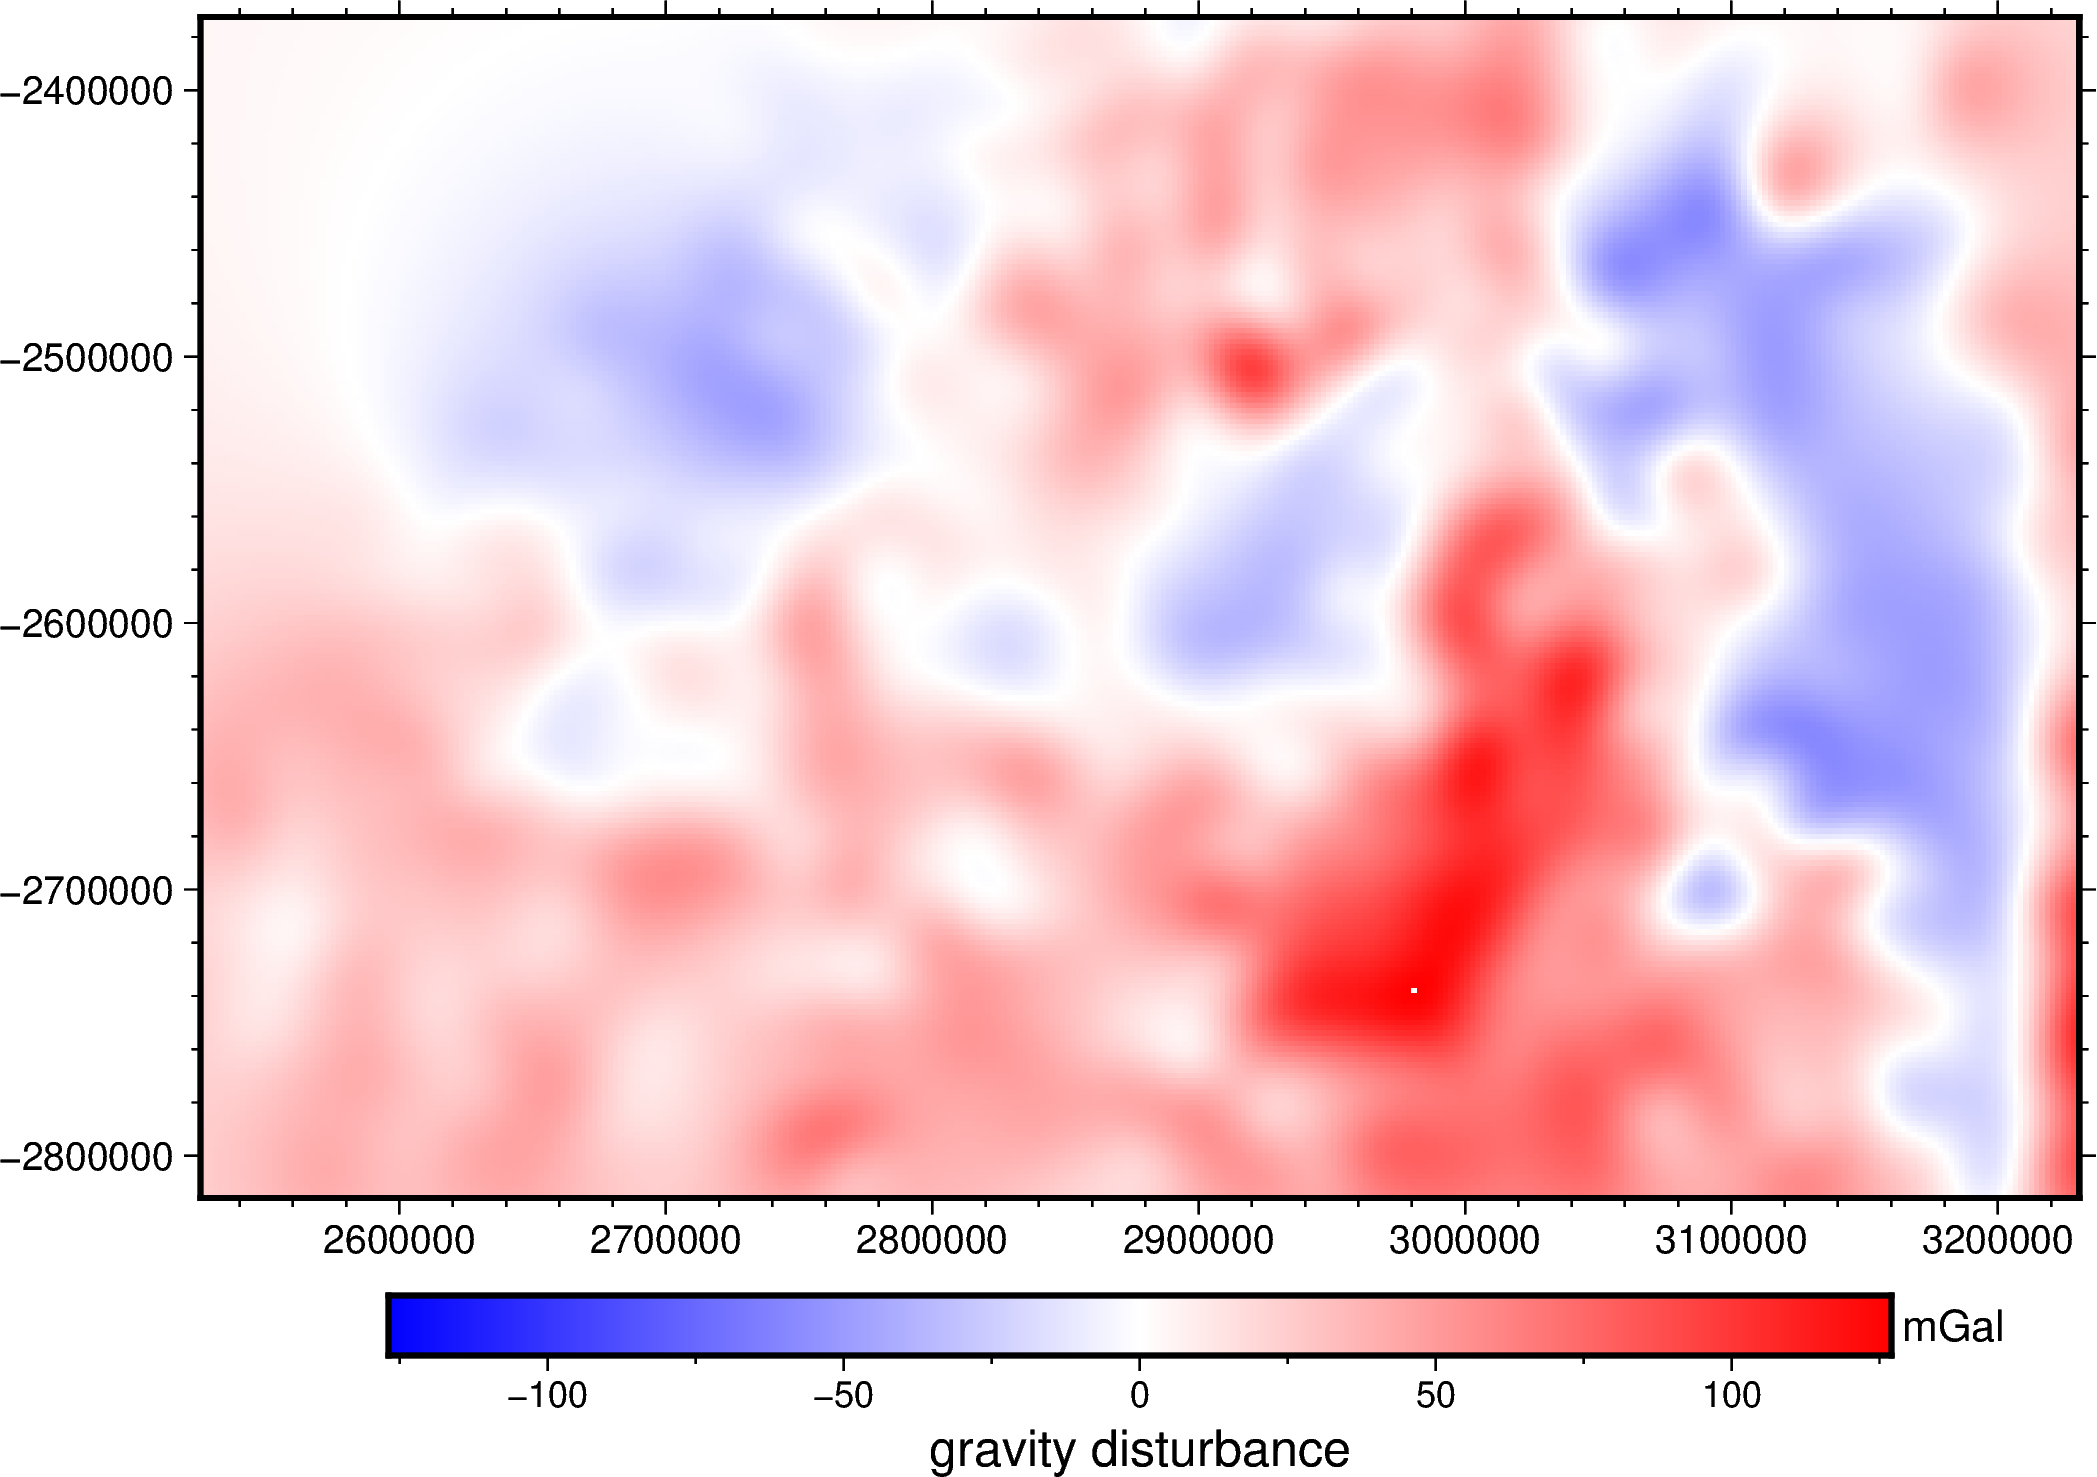

In [10]:
maxabs = vd.maxabs(grid.gravity_disturbance)

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid.gravity_disturbance,
   region=region,
   projection=fig_proj,
   cmap=True,
)
fig.colorbar(cmap=True, frame=["a50f25", "x+lgravity disturbance", "y+lmGal"])

fig.show()